In [1]:
%pip install pandas numpy matplotlib scikit-learn tensorflow ultralytics supervision umap-learn -q


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [392]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage.transform import resize


def resize_image(image, size=(128, 128)):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    contrast_img = clahe.apply(gray_img)

    return resize(contrast_img, size)


def resize_image_multychannel(image, size=(128, 128, 3)):
    resized_img_channels = resize(image, size)
    return resized_img_channels.astype(np.float32) / 255.0


def get_hog_features(image):
    features, _ = hog(image, orientations=9, 
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), 
                visualize=True,
                channel_axis=None)
    
    return features


def extract_features(row):
    img = cv2.imread(row['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x = int(row['x'])
    y = int(row['y'])
    width = int(row['width'])
    height = int(row['height'])
    
    cropped_img = img[y:y+height, x:x+width]

    resized_img = resize_image(cropped_img)
    resized_img_multychannel = resize_image_multychannel(cropped_img)
    
    features = get_hog_features(resized_img)
    
    return features, resized_img_multychannel

In [393]:
import numpy as np


LABELS_MAP = {
    'Tank': 1,
    'APC': 0
}


def prepare_dataset(df):
    features = []
    images = []
    labels = []
    
    for _, row in df.iterrows():
        label = row['label']

        image_features, image = extract_features(row)
        images.append(image)
        features.append(image_features)
        labels.append(LABELS_MAP[label])
    
    return np.array(features), np.array(images), np.array(labels)


In [394]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split


csv_path = Path.cwd() / 'data.csv'
df = pd.read_csv(csv_path)

train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_features, train_images, train_labels = prepare_dataset(train_df)
test_features, test_images, test_labels = prepare_dataset(test_df)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score


class CustomSVM:
    def __init__(self, learning_rate=0.001, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        y = np.where(y == 0, -1, 1)
        
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        
        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * 1/self.epochs * self.w)
                else:
                    self.w -= self.lr * (2 * 1/self.epochs * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]
                    
    def predict(self, X):
        linear_output = np.dot(X, self.w) + self.b
        return np.where(linear_output <= 0, 0, 1)


svm_classifier = CustomSVM()
svm_classifier.fit(train_features, train_labels)

svm_train_accuracy = accuracy_score(train_labels, svm_classifier.predict(train_features))
svm_test_accuracy = accuracy_score(test_labels, svm_classifier.predict(test_features))

print(f'SVM Accuracy on train set: {svm_train_accuracy:.2f}')
print(f'SVM Accuracy on test set: {svm_test_accuracy:.2f}')

SVM Accuracy on train set: 1.00
SVM Accuracy on test set: 0.68


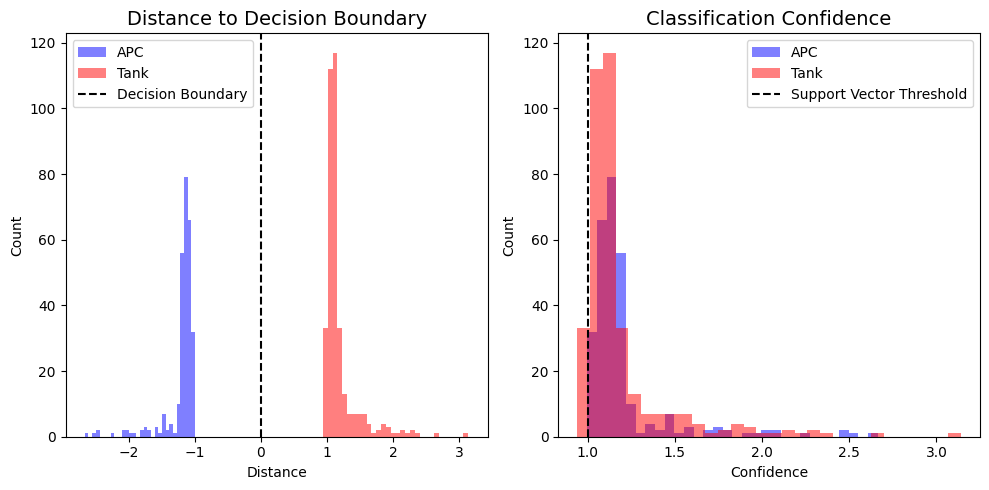

In [461]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(train_labels, svm_classifier.predict(train_features))
distances = np.dot(train_features, svm_classifier.w) + svm_classifier.b


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(distances[train_labels == 0], bins=30, alpha=0.5, label='APC', color='blue')
plt.hist(distances[train_labels == 1], bins=30, alpha=0.5, label='Tank', color='red')
plt.axvline(x=0, color='black', linestyle='--', label='Decision Boundary')
plt.title('Distance to Decision Boundary', fontsize=14)
plt.xlabel('Distance')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
confidence = np.abs(distances)
plt.hist(confidence[train_labels == 0], bins=30, alpha=0.5, label='APC', color='blue')
plt.hist(confidence[train_labels == 1], bins=30, alpha=0.5, label='Tank', color='red')
plt.axvline(x=1, color='black', linestyle='--', label='Support Vector Threshold')
plt.title('Classification Confidence', fontsize=14)
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()


Train Set Metrics:
Between-class distance: 1.4
Within-class spread: 0.3
Separation ratio: 5.4
Test Set Metrics:
Between-class distance: 1.5
Within-class spread: 0.3
Separation ratio: 4.4


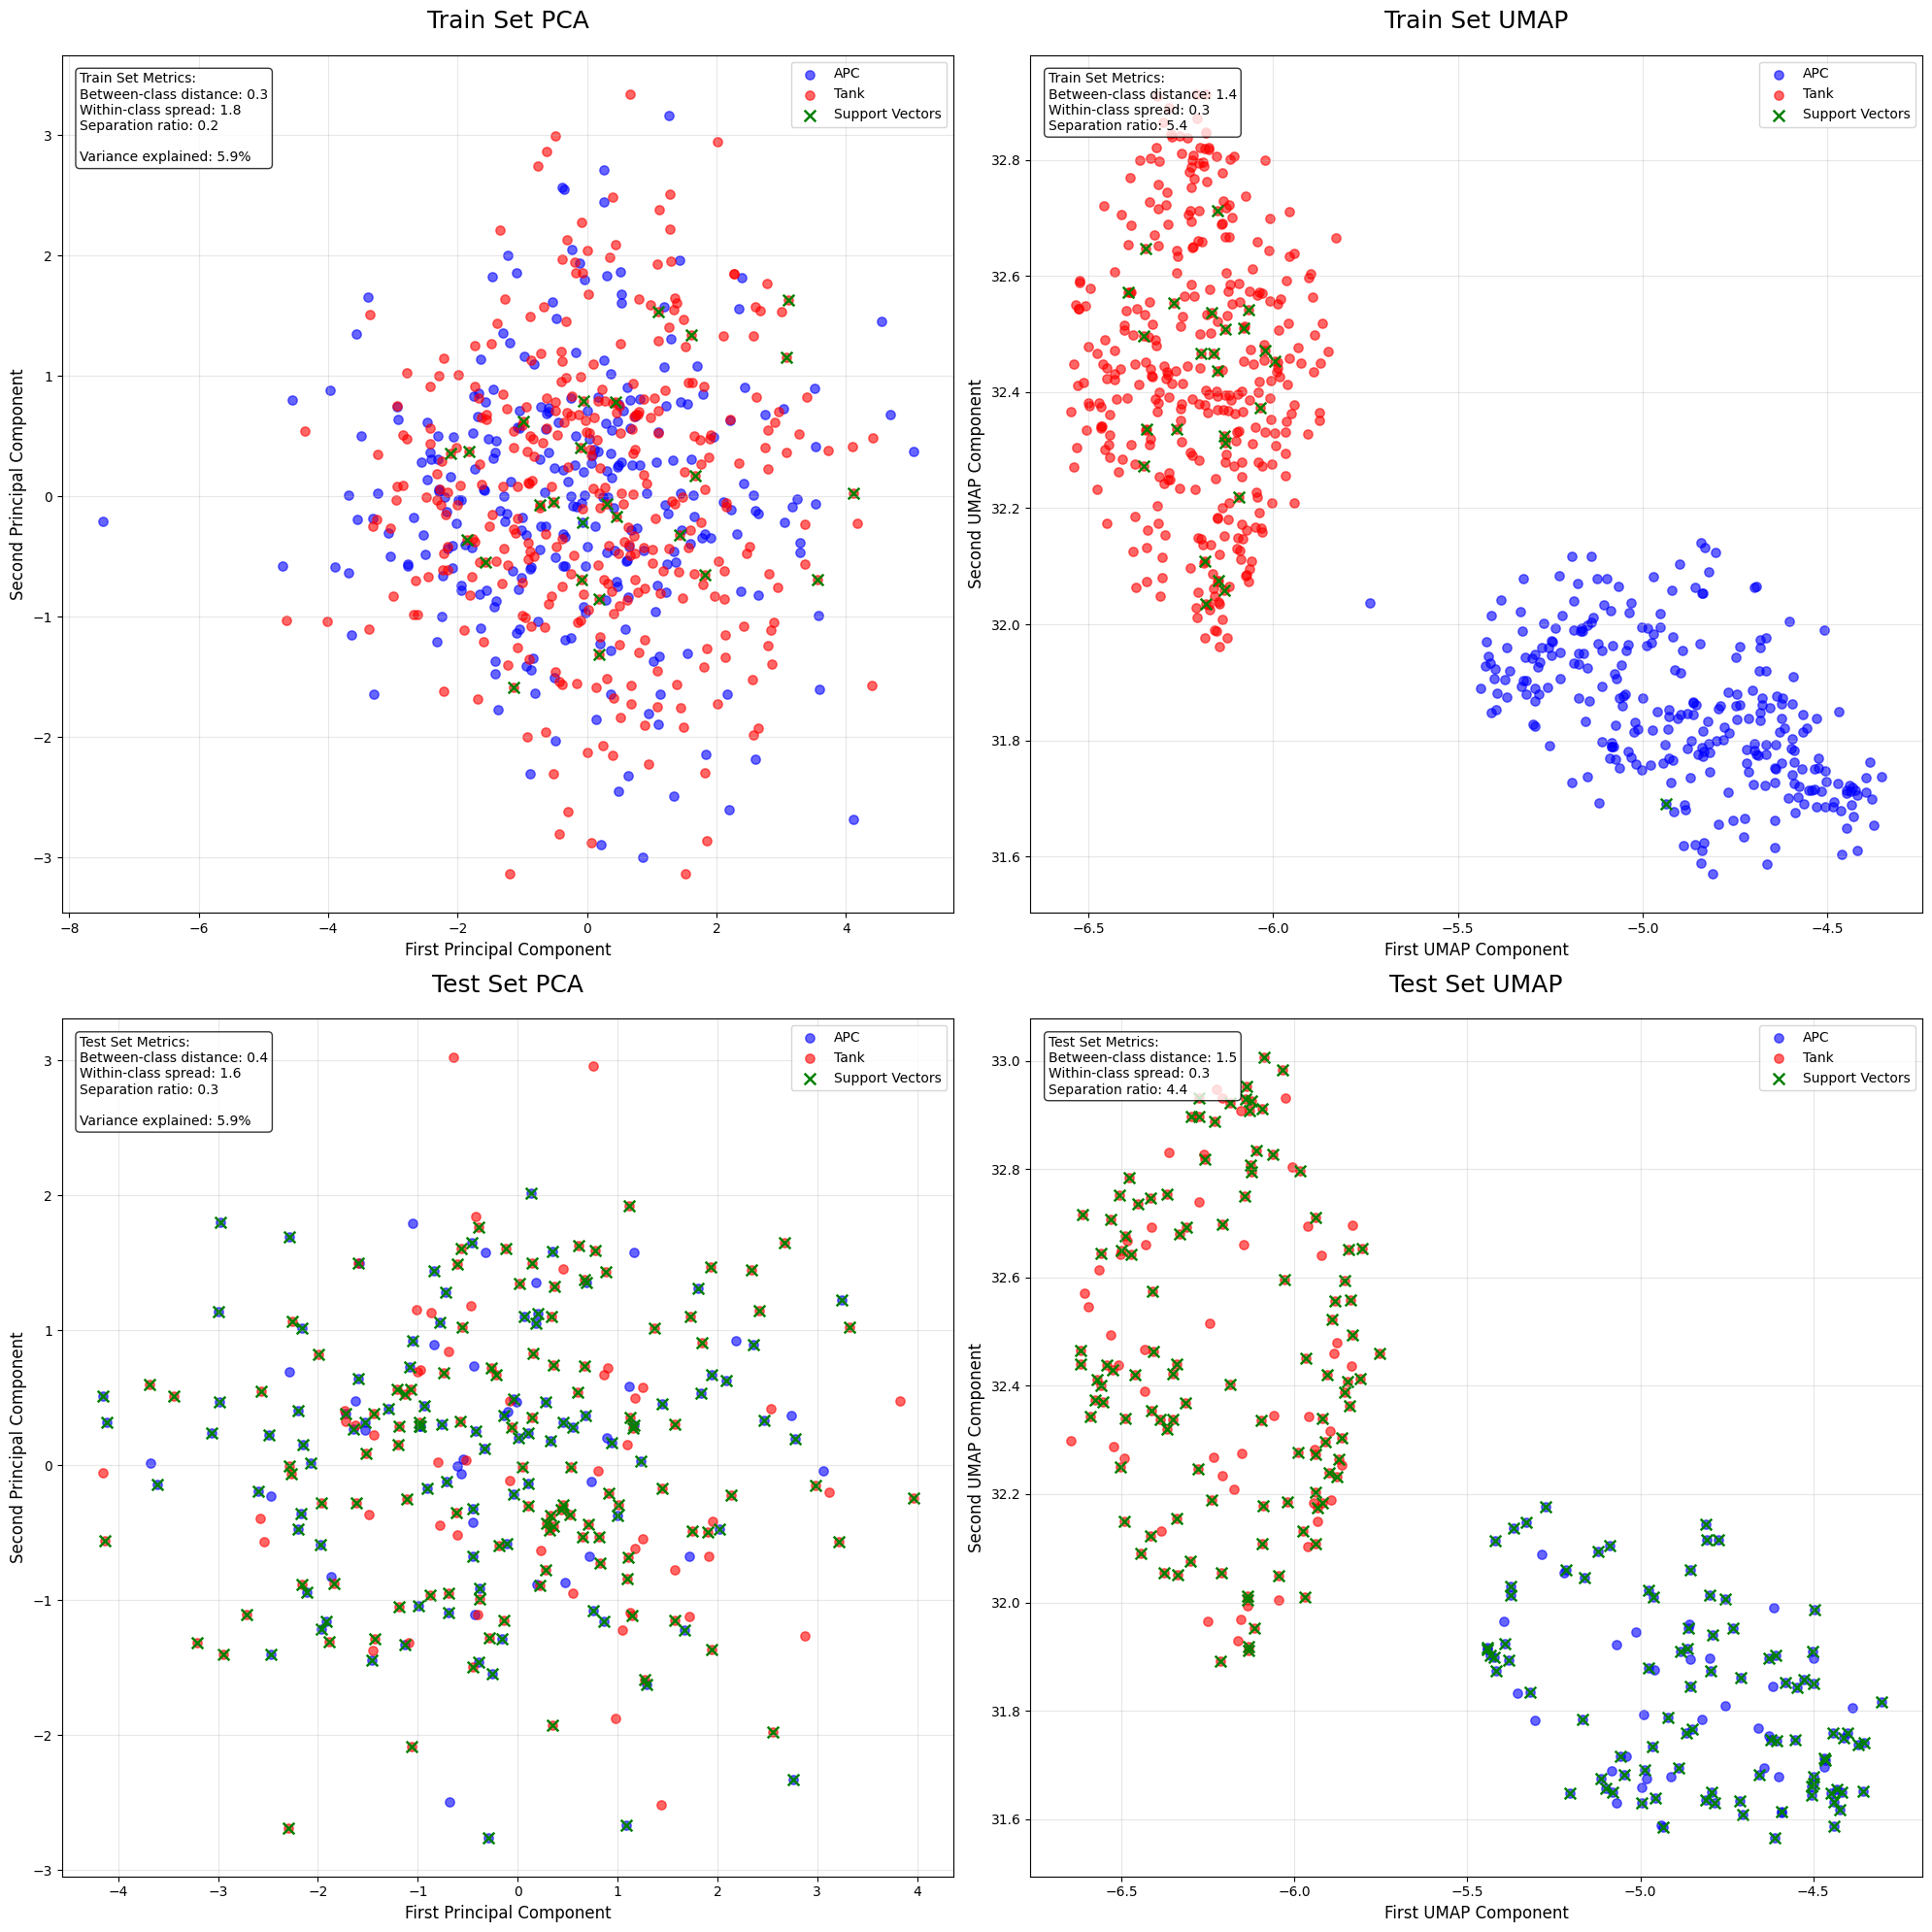

In [457]:
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def calculate_separation(X, y):
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    
    center_0 = np.mean(class_0, axis=0)
    center_1 = np.mean(class_1, axis=0)
    
    spread_0 = np.mean(np.linalg.norm(class_0 - center_0, axis=1))
    spread_1 = np.mean(np.linalg.norm(class_1 - center_1, axis=1))
    between = np.linalg.norm(center_0 - center_1)
    
    return between, (spread_0 + spread_1) / 2

def plot_projection(ax, X_2d, labels, support_vectors_mask, title, metrics_text, is_pca=True):
    ax.scatter(X_2d[labels == 0][:, 0], X_2d[labels == 0][:, 1],
              c='blue', label='APC', alpha=0.6, s=45)
    ax.scatter(X_2d[labels == 1][:, 0], X_2d[labels == 1][:, 1],
              c='red', label='Tank', alpha=0.6, s=45)
    
    ax.scatter(X_2d[support_vectors_mask][:, 0], X_2d[support_vectors_mask][:, 1],
              c='green', marker='x', s=70, linewidth=1.8, label='Support Vectors')
    
    ax.set_title(title, fontsize=18, pad=20)
    ax.set_xlabel('First Principal Component' if is_pca else 'First UMAP Component', fontsize=12)
    ax.set_ylabel('Second Principal Component' if is_pca else 'Second UMAP Component', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    ax.text(0.02, 0.98, metrics_text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


X_combined = np.vstack((train_features, test_features))
y_combined = np.concatenate((train_labels, test_labels))

pca_400 = PCA(n_components=400)
X_combined_pca = pca_400.fit_transform(X_combined)

supervised_umap = umap.UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=70,
    min_dist=0.03,
    metric='euclidean',
    target_metric='categorical',
    target_weight=0.15,
    spread=0.3
)

X_combined_umap = supervised_umap.fit_transform(X_combined_pca, y_combined)

X_train_sup_umap = X_combined_umap[:len(train_features)]
X_test_sup_umap = X_combined_umap[len(train_features):]

pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(train_features)
X_test_pca_2d = pca_2d.transform(test_features)

train_sv_mask = np.abs(np.dot(train_features, svm_classifier.w) + svm_classifier.b) <= 1
test_sv_mask = np.abs(np.dot(test_features, svm_classifier.w) + svm_classifier.b) <= 1

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))

between_train_pca, spread_train_pca = calculate_separation(X_train_pca_2d, train_labels)
separation_ratio_train_pca = between_train_pca/spread_train_pca
metrics_text_train_pca = f"Train Set Metrics:\n" \
                        f"Between-class distance: {between_train_pca:.1f}\n" \
                        f"Within-class spread: {spread_train_pca:.1f}\n" \
                        f"Separation ratio: {separation_ratio_train_pca:.1f}\n\n" \
                        f"Variance explained: {sum(pca_2d.explained_variance_ratio_):.1%}"
plot_projection(ax1, X_train_pca_2d, train_labels, train_sv_mask, 'Train Set PCA', metrics_text_train_pca)

between_train_umap, spread_train_umap = calculate_separation(X_train_sup_umap, train_labels)
separation_ratio_train_umap = between_train_umap/spread_train_umap
metrics_text_train_umap = f"Train Set Metrics:\n" \
                         f"Between-class distance: {between_train_umap:.1f}\n" \
                         f"Within-class spread: {spread_train_umap:.1f}\n" \
                         f"Separation ratio: {separation_ratio_train_umap:.1f}"
plot_projection(ax2, X_train_sup_umap, train_labels, train_sv_mask, 'Train Set UMAP', metrics_text_train_umap, False)

print(metrics_text_train_umap)

between_test_pca, spread_test_pca = calculate_separation(X_test_pca_2d, test_labels)
separation_ratio_test_pca = between_test_pca/spread_test_pca
metrics_text_test_pca = f"Test Set Metrics:\n" \
                       f"Between-class distance: {between_test_pca:.1f}\n" \
                       f"Within-class spread: {spread_test_pca:.1f}\n" \
                       f"Separation ratio: {separation_ratio_test_pca:.1f}\n\n" \
                       f"Variance explained: {sum(pca_2d.explained_variance_ratio_):.1%}"
plot_projection(ax3, X_test_pca_2d, test_labels, test_sv_mask, 'Test Set PCA', metrics_text_test_pca)

between_test_umap, spread_test_umap = calculate_separation(X_test_sup_umap, test_labels)
separation_ratio_test_umap = between_test_umap/spread_test_umap
metrics_text_test_umap = f"Test Set Metrics:\n" \
                        f"Between-class distance: {between_test_umap:.1f}\n" \
                        f"Within-class spread: {spread_test_umap:.1f}\n" \
                        f"Separation ratio: {separation_ratio_test_umap:.1f}"
plot_projection(ax4, X_test_sup_umap, test_labels, test_sv_mask, 'Test Set UMAP', metrics_text_test_umap, False)

print(metrics_text_test_umap)

plt.tight_layout()
plt.show()

In [396]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = cnn_model.fit(train_images, train_labels,
                   epochs=19,
                   batch_size=16,
                   validation_data=(test_images, test_labels))

_, cnn_train_accuracy = cnn_model.evaluate(train_images, train_labels)
_, cnn_test_accuracy = cnn_model.evaluate(test_images, test_labels)

print(f'CNN Accuracy on train set: {cnn_train_accuracy:.2f}')
print(f'CNN Accuracy on test set: {cnn_test_accuracy:.2f}')

Epoch 1/19


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.6159 - loss: 1.0026 - val_accuracy: 0.5636 - val_loss: 0.6891
Epoch 2/19
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.7636 - loss: 0.5234 - val_accuracy: 0.5636 - val_loss: 0.7436
Epoch 3/19
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8940 - loss: 0.3348 - val_accuracy: 0.5636 - val_loss: 0.8012
Epoch 4/19
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.8574 - loss: 0.3091 - val_accuracy: 0.5636 - val_loss: 0.8452
Epoch 5/19
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9496 - loss: 0.1676 - val_accuracy: 0.5636 - val_loss: 0.9171
Epoch 6/19
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9489 - loss: 0.1417 - val_accuracy: 0.5636 - val_loss: 0.9412
Epoch 7/19
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9334 - loss: 0.1625 - val_accuracy: 0.5636 - val_loss: 0.9368
Epoch 8/19
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9635 - loss: 0.1033 - val_accuracy: 0.5636 - val_loss: 0.

In [397]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
perceptron = Perceptron(max_iter=100, 
                       random_state=42,
                       eta0=0.01)

perceptron.fit(train_features, train_labels)

perceptron_train_accuracy = perceptron.score(train_features, train_labels)
perceptron_test_accuracy = perceptron.score(test_features, test_labels)

print(f'Perceptron Accuracy on train set: {perceptron_train_accuracy:.2f}')
print(f'Perceptron Accuracy on test set: {perceptron_test_accuracy:.2f}')

Perceptron Accuracy on train set: 1.00
Perceptron Accuracy on test set: 0.73


In [398]:
import numpy as np
from sklearn.metrics import accuracy_score


class CustomLDA:
    def __init__(self):
        self.means = None
        self.cov = None
        self.priors = None
        self.coef = None
        self.intercept = None

    def fit(self, X, y):
        classes = np.unique(y)
        n_classes = len(classes)
        n_features = X.shape[1]
        
        self.means = np.zeros((n_classes, n_features))
        for i, c in enumerate(classes):
            self.means[i] = np.mean(X[y == c], axis=0)
            
        self.cov = np.zeros((n_features, n_features))
        for i, c in enumerate(classes):
            diff = X[y == c] - self.means[i]
            self.cov += diff.T @ diff

        self.cov /= (len(X) - n_classes)
        self.cov += np.eye(n_features) * 1e-4
        self.priors = np.array([np.mean(y == c) for c in classes])
        
        cov_inv = np.linalg.inv(self.cov)
        self.coef = (self.means[1] - self.means[0]) @ cov_inv
        self.intercept = (-0.5 * self.means[1] @ cov_inv @ self.means[1] + 
                         0.5 * self.means[0] @ cov_inv @ self.means[0] +
                         np.log(self.priors[1] / self.priors[0]))
        return self

    def predict(self, X):
        scores = X @ self.coef.T + self.intercept
        return (scores > 0).astype(int)


lda_classifier = CustomLDA()
lda_classifier.fit(train_features, train_labels)

lda_train_accuracy = accuracy_score(train_labels, lda_classifier.predict(train_features))
lda_test_accuracy = accuracy_score(test_labels, lda_classifier.predict(test_features))

print(f'LDA Accuracy on train set: {lda_train_accuracy:.3f}')
print(f'LDA Accuracy on test set: {lda_test_accuracy:.3f}')

LDA Accuracy on train set: 1.000
LDA Accuracy on test set: 0.687



Model Performance Metrics:
           Custom SVM  Custom LDA    CNN
Accuracy        0.684       0.687  0.713
Precision       0.718       0.720  0.698
Recall          0.723       0.729  0.865
F1 Score        0.720       0.724  0.772


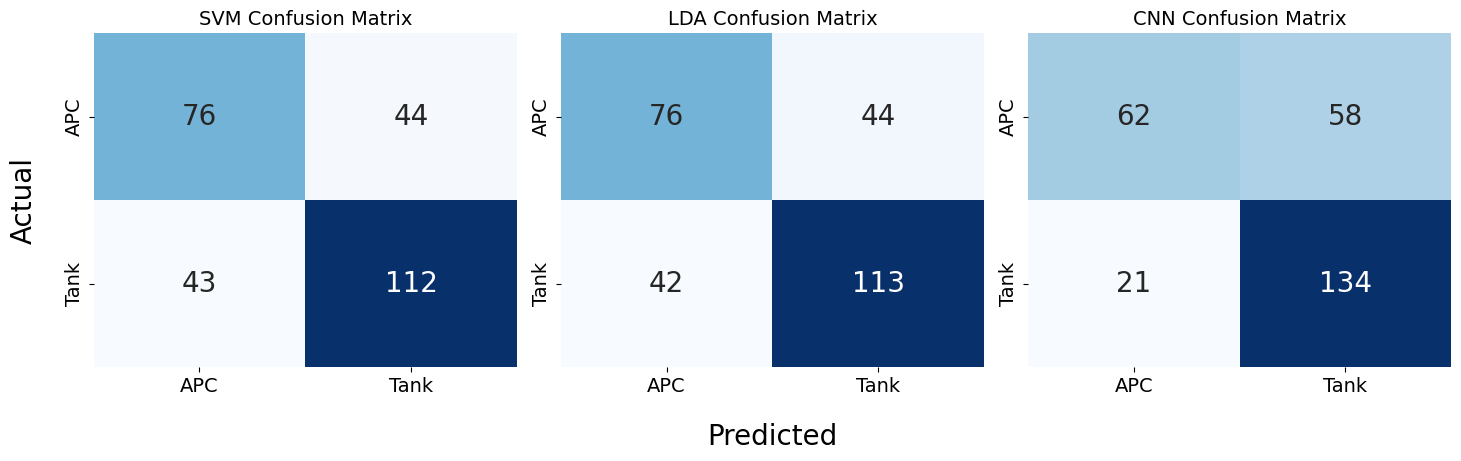

In [399]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


svm_predictions = []
cnn_predictions = []
lda_predictions = []


for i, label in enumerate(test_labels):
    svm = svm_classifier.predict(test_features[i].reshape(1, -1))
    svm_predictions.append(svm[0])
    
    lda = lda_classifier.predict(test_features[i].reshape(1, -1))
    lda_predictions.append(lda[0])

    cnn = cnn_model.predict(test_images[i].reshape(1, 128, 128, 3), verbose=0)
    cnn_predictions.append(int(cnn[0].item() > 0.5))


metrics = {}
for name, preds in [('Custom SVM', svm_predictions), 
                    ('Custom LDA', lda_predictions),
                    ('CNN', cnn_predictions)]:
    metrics[name] = {
        'Accuracy': accuracy_score(test_labels, preds),
        'Precision': precision_score(test_labels, preds),
        'Recall': recall_score(test_labels, preds),
        'F1 Score': f1_score(test_labels, preds)
    }


metrics_df = pd.DataFrame(metrics).round(3)
print("\nModel Performance Metrics:")
print(metrics_df)


plt.figure(figsize=(15, 5))
plt.xlabel('Predicted', fontsize=20, labelpad=40)
plt.ylabel('Actual', fontsize=20, labelpad=40)
plt.xticks([])
plt.yticks([])
plt.box(False)

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(test_labels, svm_predictions), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['APC', 'Tank'],
            yticklabels=['APC', 'Tank'],
            annot_kws={'size': 20})
plt.title('SVM Confusion Matrix', fontsize=14)
plt.tick_params(labelsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(test_labels, lda_predictions), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['APC', 'Tank'],
            yticklabels=['APC', 'Tank'],
            annot_kws={'size': 20})
plt.title('LDA Confusion Matrix', fontsize=14)
plt.tick_params(labelsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(test_labels, cnn_predictions), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['APC', 'Tank'],
            yticklabels=['APC', 'Tank'],
            annot_kws={'size': 20})
plt.title('CNN Confusion Matrix', fontsize=14)
plt.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

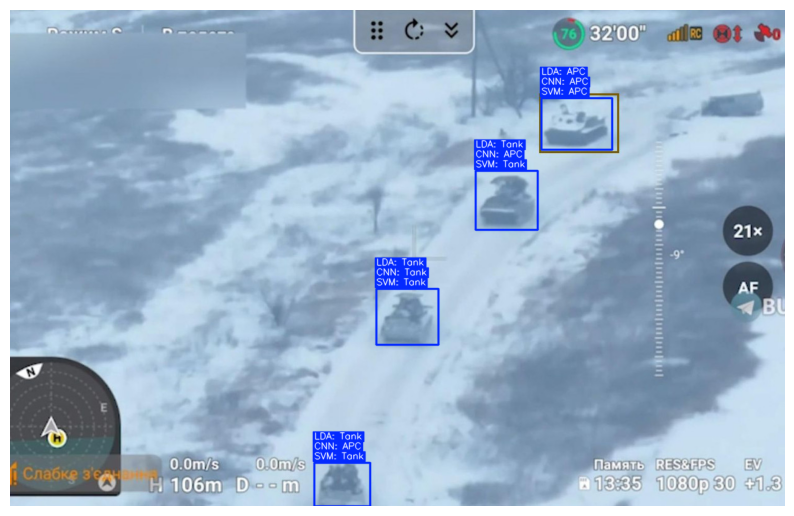

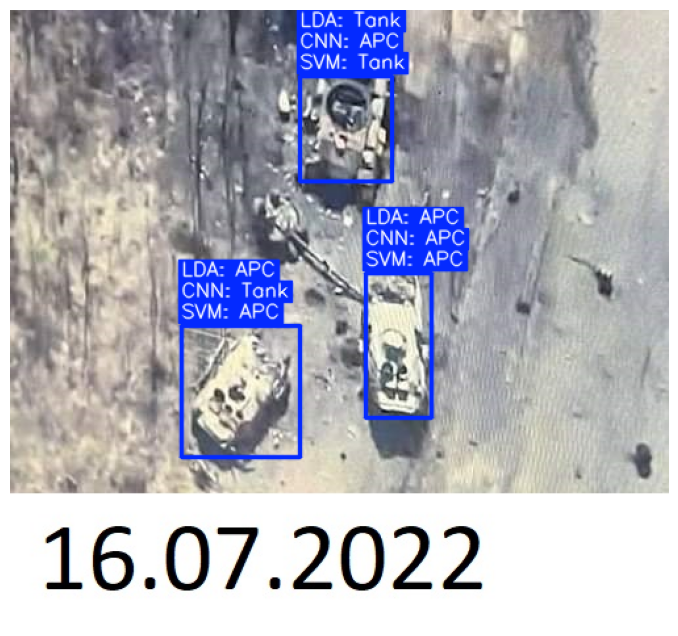

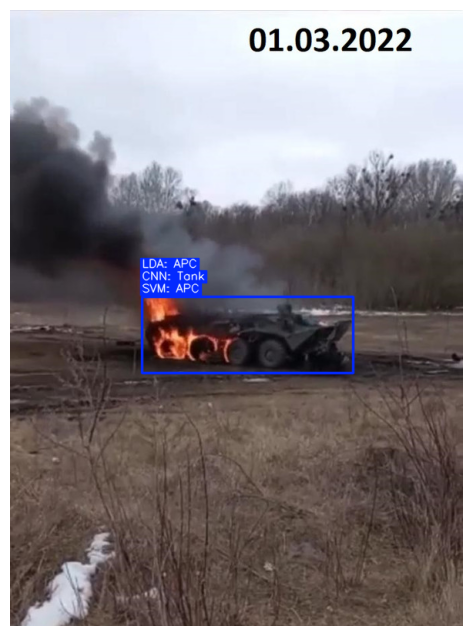

In [400]:
from ultralytics.utils.plotting import Annotator, colors


demo = pd.read_csv("demo.csv")
demo = demo.groupby('image_path').agg(lambda x: list(x)).reset_index()


def draw_labels(image):
    for x, y, w, h in zip(row['x'], row['y'], row['width'], row['height']):
        labels = []
        box = [int(x), int(y), int(x + w), int(y + h)]

        cropped_img = image[y:y+h, x:x+w]
        resized_image = resize_image(cropped_img)
        resized_img_multychannel = resize_image_multychannel(cropped_img)
        features = get_hog_features(resized_image)

        svm_pred = svm_classifier.predict(features.reshape(1, -1))
        labels.append("SVM: Tank" if svm_pred[0] == 1 else "SVM: APC")

        cnn_pred = cnn_model.predict(resized_img_multychannel.reshape(1, 128, 128, 3), verbose=0)
        labels.append("CNN: Tank" if cnn_pred[0].item() > 0.5 else "CNN: APC")

        lda_pred = lda_classifier.predict(features.reshape(1, -1))
        labels.append("LDA: Tank" if lda_pred[0] == 1 else "LDA: APC")
        
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), colors(0), 2, cv2.LINE_AA) 
        
        for i, label in enumerate(labels):
            label_x = box[0]
            label_y = box[1] - (i + 1) * 16
            (text_width, text_height), _ = cv2.getTextSize(label, 0, 0.5, 1)

            cv2.rectangle(image, 
                        (label_x - 2, label_y - 2), 
                        (label_x + text_width + 2, label_y + text_height + 2),
                        colors(0), -1, cv2.LINE_AA)
            cv2.putText(
                image,
                label,
                (label_x, label_y + text_height - 2),
                0,
                0.5,
                (255, 255, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )


for _, row in demo.iterrows():
    image = cv2.imread(row['image_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    annotator = Annotator(image, line_width=2)
    draw_labels(image)

    plt.figure(figsize=(10, 8))
    plt.imshow(annotator.result())
    plt.axis('off')
    plt.show()